## Recommender Systems

Source and inspiration: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson4.ipynb

In [53]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import defaultdict
import torch.distributions as distributions
import pandas as pd
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from operator import itemgetter
from pprint import PrettyPrinter
import seaborn as sns
%matplotlib inline

In [2]:
movie_data = pd.read_csv("../small_data/movie_data.tsv", sep='\t', names=['user', 'item', 'rating', 'timestamp'])
movie_data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
movie_info = pd.read_csv("../small_data/u.item", sep="|", encoding="latin-1", header=None)
movie_info.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
movie_name_dict = movie_info.set_index(0)[1].to_dict()

In [29]:
user_to_index = {u:i for i, u in enumerate(movie_data.user.unique())}
item_to_index = {u:i for i, u in enumerate(movie_data.item.unique())}
index_to_item = {i:item for item, i in item_to_index.items()}

In [6]:
class CollaborativeFiltering(nn.Module):
    def __init__(self, user_size, item_size, embedding_dim):
        super(CollaborativeFiltering, self).__init__()
        
        self.user_embedding = nn.Embedding(user_size, embedding_dim)
        self.item_embedding = nn.Embedding(item_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim*2, embedding_dim)  # bias is True by default
        self.linear2 = nn.Linear(embedding_dim, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, user, item):
        user_embeds = self.user_embedding(user)
        item_embeds = self.item_embedding(item)
        drop_cat = self.dropout(torch.cat([user_embeds, item_embeds], 2))
        first_layer = self.relu(self.linear1(drop_cat))
        return self.linear2(self.dropout(first_layer))
    
    def get_user_emdedding(self, user):
        user_variable = Variable(torch.LongTensor([user_to_index[user]]))
        return self.user_embedding(user_variable).view(1,-1)
    
    def get_item_emdedding(self, item):
        item_variable = Variable(torch.LongTensor([item_to_index[item]]))
        return self.item_embedding(item_variable).view(1,-1)

In [7]:
training_fraction = 0.8
data = movie_data[['user', 'item', 'rating']].values
training_cutoff = int(data.shape[0] * training_fraction)
training_data = data[:training_cutoff]
testing_data = data[training_cutoff:]

In [8]:
cf = CollaborativeFiltering(len(user_to_index), len(item_to_index), 50)
criterion = nn.MSELoss()
optimizer = optim.Adam(cf.parameters(), lr = 0.001)

In [9]:
def get_variable(value):
    tensor = torch.LongTensor([value])
    return Variable(tensor)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(user, item, rating):
    cf.zero_grad()
    predicted_rating = cf.forward(user, item)
    loss = criterion(predicted_rating, rating)
    loss.backward()
    optimizer.step()
    return loss.data

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        row = self.data[index]
        return (torch.LongTensor([user_to_index[row[0]]]), 
                torch.LongTensor([item_to_index[row[1]]]), 
                torch.FloatTensor([int(row[2])]))
        
    def __len__(self):
        return len(self.data)

batch_size = 8
training_dataset = CustomDataset(training_data)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

In [12]:
n_epochs = 8
print_every_batch = int(15000/batch_size)
plot_every_batch = int(1000/batch_size)
all_losses = []
total_loss = 0 # Reset every plot_every iters
iter = 0

start = time.time()

for epoch in range(1, n_epochs + 1):
    for i_batch, sample_batched in enumerate(training_dataloader):
        loss = train(Variable(sample_batched[0]), Variable(sample_batched[1]), Variable(sample_batched[2]))
        total_loss += loss

        if iter % (print_every_batch*batch_size) == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / (len(data) * n_epochs) * 100, loss))

        if iter % (plot_every_batch*batch_size) == 0 and iter != 0:
            all_losses.append(total_loss / plot_every_batch)
            total_loss = 0
        
        iter = iter + batch_size

0m 0s (0 0%) 6.7452
0m 5s (15000 3%) 0.3068
0m 13s (30000 7%) 1.4974
0m 21s (45000 11%) 1.1739
0m 30s (60000 15%) 1.7775
0m 38s (75000 18%) 1.7976
0m 47s (90000 22%) 1.4010
0m 55s (105000 26%) 1.2469
1m 4s (120000 30%) 0.6356
1m 13s (135000 33%) 0.8279
1m 22s (150000 37%) 0.1165
1m 31s (165000 41%) 1.3693
1m 41s (180000 45%) 0.7099
1m 51s (195000 48%) 2.4649
2m 0s (210000 52%) 0.3932
2m 10s (225000 56%) 0.3831
2m 19s (240000 60%) 0.6127
2m 28s (255000 63%) 0.4247
2m 37s (270000 67%) 0.8066
2m 47s (285000 71%) 1.6275
2m 56s (300000 75%) 1.1797
3m 6s (315000 78%) 1.3523


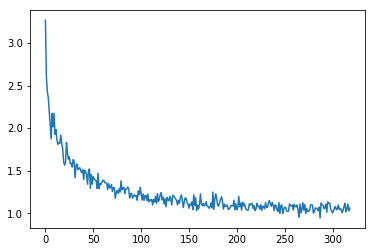

In [13]:
plt.plot(all_losses)

## Test Results

In [50]:
testing_dataset = CustomDataset(testing_data)
testing_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=False)
testing_losses = []
for t in testing_dataloader:
    predicted_test_rating = cf.forward(Variable(t[0]), Variable(t[1]))
    loss = criterion(predicted_test_rating, Variable(t[2]))
    testing_losses.append(loss)
testing_losses = np.array(testing_losses)
print(np.mean(np.sqrt(testing_losses)))

Variable containing:
 0.8250
[torch.FloatTensor of size 1]



## PCA of Movie Embeddings

In [14]:
item_keys = list(item_to_index.keys())
item_features = np.array([cf.get_item_emdedding(i).data.numpy()[0] for i in item_keys])

In [15]:
item_features.shape

(1590, 50)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(item_features.T).components_

In [44]:
def print_pca(movie_pca, component):
    movie_comp = [(c, movie_name_dict[index_to_item[i]]) for i, c in enumerate(movie_pca[component])]
    sorted_movies = sorted(movie_comp, key=itemgetter(0), reverse=True)
    pp = PrettyPrinter()
    print("COMPONENT {}".format(component))
    print("Highest")
    pp.pprint(sorted_movies[:10])
    print("Lowest")
    pp.pprint(sorted_movies[-10:])

In [45]:
print_pca(movie_pca, 0)

COMPONENT 0
Highest
[(0.068440646, 'Island of Dr. Moreau, The (1996)'),
 (0.06708388, 'Flintstones, The (1994)'),
 (0.066391572, 'George of the Jungle (1997)'),
 (0.065295324, 'Escape from L.A. (1996)'),
 (0.06177314, 'Bio-Dome (1996)'),
 (0.060572643, 'Volcano (1997)'),
 (0.058098994, 'Another Stakeout (1993)'),
 (0.055939771, 'Striptease (1996)'),
 (0.05542089, 'Booty Call (1997)'),
 (0.054703224, 'Sgt. Bilko (1996)')]
Lowest
[(-0.065547727, "Schindler's List (1993)"),
 (-0.066286311, 'Silence of the Lambs, The (1991)'),
 (-0.06684573, 'Close Shave, A (1995)'),
 (-0.067127824, 'Casablanca (1942)'),
 (-0.068266936, 'Shawshank Redemption, The (1994)'),
 (-0.069126047, 'Star Wars (1977)'),
 (-0.06953273, 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (-0.070808657, 'Rear Window (1954)'),
 (-0.071925856, 'Shall We Dance? (1996)'),
 (-0.072629355, 'Secrets & Lies (1996)')]
